In [241]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import norm,gamma,chi2, expon, t
from scipy.stats.distributions import gamma
from scipy import stats
from scipy.stats import kstest
from pymc3 import Model, Exponential, Gamma, Normal,Uniform

from scipy.special import expit
RANDOM_SEED = 20090425

In [242]:
# Load CSV file into a DataFrame
df = pd.read_csv('data/cumulative-area-burnt-by-wildfires-by-week.csv')
for i in range(0,13):
    df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].fillna(0, inplace=True)
    df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'] = df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].div(10**6)

print(df.head())


        Entity Code  Week  Y2024_Cumulative_Area_Burnt  \
0  Afghanistan  AFG     1                     0.000391   
1  Afghanistan  AFG     2                     0.000559   
2  Afghanistan  AFG     3                     0.000841   
3  Afghanistan  AFG     4                     0.000841   
4  Afghanistan  AFG     5                     0.000841   

   Y2023_Cumulative_Area_Burnt  Y2022_Cumulative_Area_Burnt  \
0                          0.0                     0.000000   
1                          0.0                     0.000000   
2                          0.0                     0.000000   
3                          0.0                     0.000000   
4                          0.0                     0.000215   

   Y2021_Cumulative_Area_Burnt  Y2020_Cumulative_Area_Burnt  \
0                     0.001246                     0.000000   
1                     0.002680                     0.000963   
2                     0.003539                     0.001181   
3                   

In [243]:
for i in range(1,13):
    df['Y'+str(2024-i)+'_Weekly_Area_Burnt'] = df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].diff().fillna(df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'])
    
    

In [244]:
total_Cumulative_Area_Burnt=0
total_Weekly_Area_Burnt=0
for i in range(1,13):
    total_Cumulative_Area_Burnt=total_Cumulative_Area_Burnt+df['Y'+str(2024-i)+'_Cumulative_Area_Burnt']
    
for i in range(1,13):
    total_Weekly_Area_Burnt=total_Weekly_Area_Burnt+df['Y'+str(2024-i)+'_Weekly_Area_Burnt']
    
    
df['Total_Cumulative_Area_Burnt']=total_Cumulative_Area_Burnt
df['Avg_Cumulative_Area_Burnt']=df['Total_Cumulative_Area_Burnt']/(12)
df['Total_Weekly_Area_Burnt']=total_Weekly_Area_Burnt
df['Avg_Weekly_Area_Burnt']=df['Total_Weekly_Area_Burnt']/(12)


print(df.head())

        Entity Code  Week  Y2024_Cumulative_Area_Burnt  \
0  Afghanistan  AFG     1                     0.000391   
1  Afghanistan  AFG     2                     0.000559   
2  Afghanistan  AFG     3                     0.000841   
3  Afghanistan  AFG     4                     0.000841   
4  Afghanistan  AFG     5                     0.000841   

   Y2023_Cumulative_Area_Burnt  Y2022_Cumulative_Area_Burnt  \
0                          0.0                     0.000000   
1                          0.0                     0.000000   
2                          0.0                     0.000000   
3                          0.0                     0.000000   
4                          0.0                     0.000215   

   Y2021_Cumulative_Area_Burnt  Y2020_Cumulative_Area_Burnt  \
0                     0.001246                     0.000000   
1                     0.002680                     0.000963   
2                     0.003539                     0.001181   
3                   

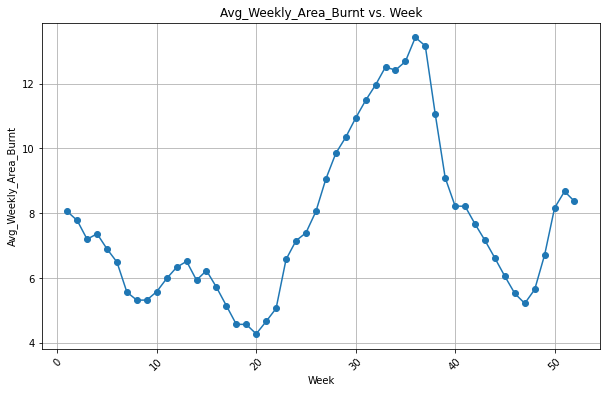

In [245]:

# Assuming 'Week' and 'Total' are columns in your DataFrame, and it is named 'df'
# You may need to adjust column names accordingly
# Also assuming df is sorted by week

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Week'], filtered_df['Avg_Weekly_Area_Burnt'], marker='o', linestyle='-')
plt.title('Avg_Weekly_Area_Burnt vs. Week')
plt.xlabel('Week')
plt.ylabel('Avg_Weekly_Area_Burnt')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.show()


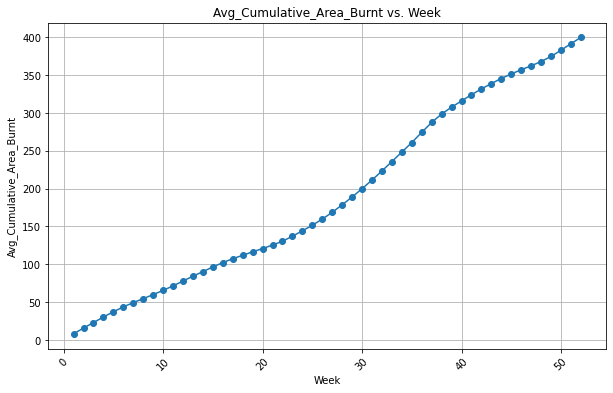

In [246]:
import matplotlib.pyplot as plt

# Assuming 'Week' and 'Total' are columns in your DataFrame, and it is named 'df'
# You may need to adjust column names accordingly
# Also assuming df is sorted by week

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Week'], filtered_df['Avg_Cumulative_Area_Burnt'], marker='o', linestyle='-')
plt.title('Avg_Cumulative_Area_Burnt vs. Week')
plt.xlabel('Week')
plt.ylabel('Avg_Cumulative_Area_Burnt')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.show()


# Wildfire Area Burnt Data Modeling: Dataset Selection Guide

The dataset for modeling wildfire burnt areas has 2 choice.

## 1. Average Weekly Burnt Area

### Pros:
- **Simplicity**: Focuses on the area burnt each week independently, making the analysis straightforward and interpretable.
- **Seasonal and Weekly Variability**: Allows detection of seasonal trends and weekly fluctuations, crucial for short-term planning and response.
- **Predictive Utility**: Typically more useful for operational decision-making, such as allocating resources based on expected weekly fire behavior.

### Cons:
- **No Long-Term Trends**: Does not capture longer-term accumulations or compounding effects, which are important for understanding the full progression of wildfire seasons.

## 2. Average Cumulative Weekly Burnt Area

### Pros:
- **Long-Term Insights**: Accumulates burnt area data over time, providing insights into the overall severity and progression of a wildfire season.
- **Modeling Progressive Risk**: Useful in risk assessment models where understanding cumulative effects (like resource depletion or ecological damage) is important.
- **Data Smoothing**: Reduces the impact of weekly volatility and may reveal underlying trends obscured by short-term fluctuations.

### Cons:
- **Complexity in Interpretation**: Since each value depends on the sum of all previous weeks, cumulative data can complicate the isolation of effects from specific variables or interventions.
- **Delayed Responses**: Less effective for immediate resource allocation decisions as it reflects an aggregation rather than current conditions.

## Decision Factors

### Objective of Analysis:
- **Immediate Fire Threats and Weekly Operations**: If the goal is to understand and respond to immediate fire threats and manage weekly operations, **average weekly burnt area** is more practical, enabling agile responses and straightforward analysis.

### Research and Policy Planning:
- **Long-Term Impacts and Policy Development**: For analyses aimed at understanding long-term impacts, policy development, or the cumulative effects of wildfires over a season, **average cumulative weekly burnt area** offers deeper insights.

### Statistical Modeling Needs:
- **Immediate Action**: For predictive modeling requiring immediate action (e.g., deploying firefighting resources), non-cumulative data is more directly applicable.
- **Long-Term Studies and Planning**: For studies on sustained conditions or long-term planning, cumulative data provides a more suitable framework.

In this notebook we choosed Average Weekly Burnt Area



In [247]:
code = 'World'  # Replace 'AFG' with the code you want to filter by
filtered_df = df[df['Entity'] == code]
print(filtered_df.head())



      Entity      Code  Week  Y2024_Cumulative_Area_Burnt  \
13208  World  OWID_WRL     1                     7.706102   
13209  World  OWID_WRL     2                    16.405835   
13210  World  OWID_WRL     3                    25.033458   
13211  World  OWID_WRL     4                    33.018512   
13212  World  OWID_WRL     5                    39.035740   

       Y2023_Cumulative_Area_Burnt  Y2022_Cumulative_Area_Burnt  \
13208                     7.273826                     6.823054   
13209                    13.923805                    13.529661   
13210                    20.180952                    21.414932   
13211                    25.118072                    30.536682   
13212                    31.933184                    37.957364   

       Y2021_Cumulative_Area_Burnt  Y2020_Cumulative_Area_Burnt  \
13208                     6.243280                     8.420206   
13209                    13.612986                    19.669008   
13210                    22.0

In [248]:
filtered_df.Avg_Weekly_Area_Burnt.head()

13208    8.051671
13209    7.774560
13210    7.193058
13211    7.363055
13212    6.894555
Name: Avg_Weekly_Area_Burnt, dtype: float64


# The filtered_Avg_Weekly_Area_Burnt_sorted_dict lists weeks with the most wildfire damage, starting with the highest.

In [249]:
indexed_values = list(enumerate(filtered_df.Avg_Weekly_Area_Burnt))

# Sort the list of tuples by value in descending order
sorted_indexed_values = sorted(indexed_values, key=lambda x: x[1], reverse=True)

# Convert the sorted list of tuples to a dictionary
filtered_Avg_Weekly_Area_Burnt_sorted_dict = {index+1: value for index, value in sorted_indexed_values}
print(filtered_Avg_Weekly_Area_Burnt_sorted_dict)

{36: 13.426075000000004, 37: 13.162869166666672, 35: 12.681772499999996, 33: 12.512499999999998, 34: 12.414045000000002, 32: 11.957402500000006, 31: 11.479864166666658, 38: 11.057137499999996, 30: 10.935481666666673, 29: 10.341950833333337, 28: 9.843994166666661, 39: 9.091939166666661, 27: 9.051247499999997, 51: 8.671124166666672, 52: 8.362870833333327, 40: 8.217242500000006, 41: 8.211644166666668, 50: 8.161629166666666, 1: 8.051671083333334, 26: 8.050682500000002, 2: 7.774559583333333, 42: 7.6648524999999905, 25: 7.391572000000001, 4: 7.363055166666666, 3: 7.193058, 43: 7.156863333333324, 24: 7.147311500000001, 5: 6.894555083333333, 49: 6.714519166666666, 44: 6.6097291666666775, 23: 6.570019833333336, 13: 6.511363333333333, 6: 6.487451000000001, 12: 6.327408166666667, 15: 6.2266328333333325, 45: 6.048586666666661, 11: 5.981754999999997, 14: 5.930056666666669, 16: 5.714204666666667, 48: 5.643803333333338, 10: 5.576304000000003, 7: 5.559184833333333, 46: 5.518562500000011, 9: 5.31504583

In [250]:
Avg_Weekly_Area_Burnt_mean = filtered_df.Avg_Weekly_Area_Burnt.mean()
Avg_Weekly_Area_Burnt_std = filtered_df.Avg_Weekly_Area_Burnt.std()
Avg_Weekly_Area_Burnt_mean,Avg_Weekly_Area_Burnt_std

(7.688282056089743, 2.5024257015459352)

In [251]:
Avg_Cumulative_Area_Burnt_mean=filtered_df.Avg_Cumulative_Area_Burnt.mean()
Avg_Cumulative_Area_Burnt_std=filtered_df.Avg_Cumulative_Area_Burnt.std()
Avg_Cumulative_Area_Burnt_mean,Avg_Cumulative_Area_Burnt_std

(191.18350215865382, 122.11372720558374)

<AxesSubplot:>

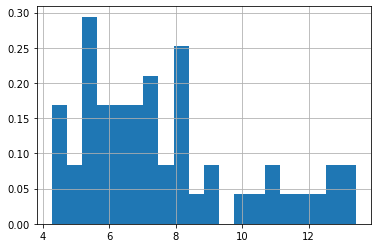

In [252]:
filtered_df.Avg_Weekly_Area_Burnt.hist(density=True, bins=20)

In [253]:
params = stats.gamma.fit(filtered_df.Avg_Weekly_Area_Burnt)
norm_dist_fitted = stats.gamma(*params)
D, p = stats.kstest(filtered_df.Avg_Weekly_Area_Burnt, norm_dist_fitted.cdf)

print(f"KS Statistic: {D}, p-value: {p}")
# Gamma: KS Statistic: 0.061551429628492804, p-value: 0.9823432098461718
# norm: KS Statistic: 0.12702982139109276, p-value: 0.3417923770028968


KS Statistic: 0.061551429628492804, p-value: 0.9823432098461718


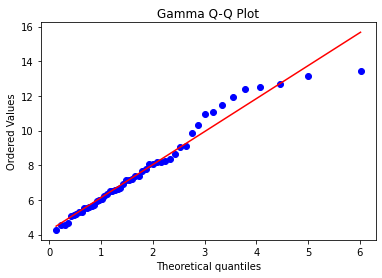

In [254]:
# Quantitile plot


stats.probplot(filtered_df.Avg_Weekly_Area_Burnt, dist="gamma", sparams=(a,), plot=plt)
plt.title('Gamma Q-Q Plot')
plt.show()


In [255]:
#per year  the prob of avg area burning btw (200-250) hectre is <0.002, (80,120)>0.004
# means that in 'y' year in 'x' week prob of avg area burning btw (200-250) is <0.002, (80,120)>0.004

In [256]:
Avg_Weekly_Area_Burnt_alpha_mom = Avg_Weekly_Area_Burnt_mean ** 2 / Avg_Weekly_Area_Burnt_std
Avg_Weekly_Area_Burnt_beta_mom = Avg_Weekly_Area_Burnt_std / Avg_Weekly_Area_Burnt_mean
Avg_Weekly_Area_Burnt_alpha_mom, Avg_Weekly_Area_Burnt_beta_mom

(23.62095343628986, 0.3254856785026261)

In [257]:
# Avg_Cumulative_Area_Burnt_alpha_mom = Avg_Cumulative_Area_Burnt_mean ** 2 / Avg_Cumulative_Area_Burnt_std
# Avg_Cumulative_Area_Burnt_beta_mom = Avg_Cumulative_Area_Burnt_std / Avg_Cumulative_Area_Burnt_mean
# Avg_Cumulative_Area_Burnt_alpha_mom, Avg_Cumulative_Area_Burnt_beta_mom

2.4782471084170985


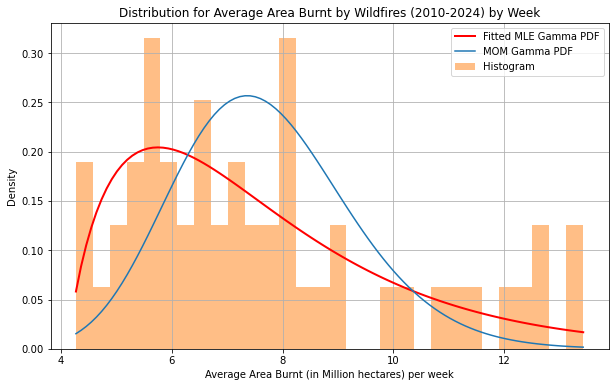

In [258]:
# Historical values
historical_values = filtered_df.Avg_Weekly_Area_Burnt

# Calculate mean and standard deviation
mean = np.mean(historical_values)
std_dev = np.std(historical_values)
print(std_dev)
# Generate data for the normal distribution curve
x = np.linspace(min(historical_values), max(historical_values), 100)
y1=gamma.pdf(x, a=Avg_Weekly_Area_Burnt_alpha_mom, scale=Avg_Weekly_Area_Burnt_beta_mom)
a, loc, scale = gamma.fit(historical_values)
y = gamma.pdf(x, a, loc, scale)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'r-', lw=2, label='Fitted MLE Gamma PDF')
plt.plot(x, y1, label='MOM Gamma PDF')
plt.hist(historical_values, bins=30, density=True, alpha=0.5, label='Histogram')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024) by Week')
plt.xlabel('Average Area Burnt (in Million hectares) per week')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [259]:


with Model() as wildfire_avg_area_burnt_gamma_model:
    ealpha = Exponential('ealpha', 1/9.)
    ebeta = Exponential('ebeta', 1/9.)
    wildfire_avg_area_burnt_like = Gamma('wildfire_avg_area_burnt_like', alpha=ealpha, beta=ebeta, observed=historical_values)

Finished [100%]: Average Loss = 167.81
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Anurag\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


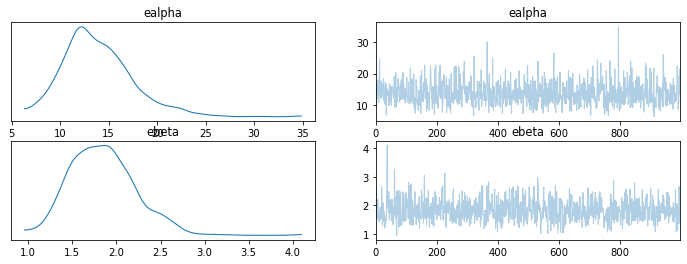

In [260]:
from pymc3 import fit
import arviz as az

with wildfire_avg_area_burnt_gamma_model: 
    wildfire_avg_area_burnt_trace_gamma = fit(random_seed=RANDOM_SEED).sample(1000)
    
az.plot_trace(wildfire_avg_area_burnt_trace_gamma)
plt.show()    

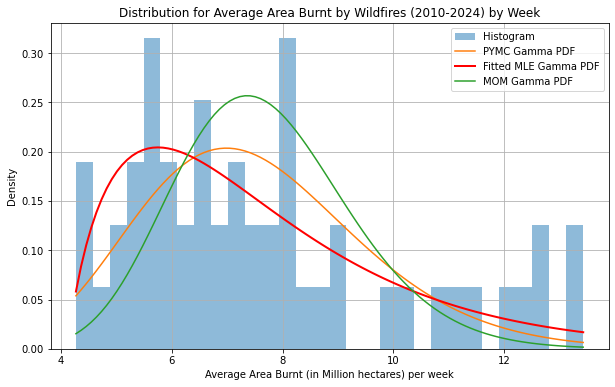

In [261]:

ealpha_posterior_mean = wildfire_avg_area_burnt_trace_gamma['ealpha'].mean()
ebeta_posterior_mean = wildfire_avg_area_burnt_trace_gamma['ebeta'].mean()

x=np.linspace(min(historical_values), max(historical_values), 100)
mom_gamma_y=gamma.pdf(x, a=Avg_Weekly_Area_Burnt_alpha_mom, scale=Avg_Weekly_Area_Burnt_beta_mom)
a, loc, scale = gamma.fit(historical_values)
mle_gamma_y = gamma.pdf(x, a, loc, scale)
pymc_gamma_y =gamma.pdf(x, ealpha_posterior_mean, scale=1/ebeta_posterior_mean)
# plt.hist(Avg_Wildfire_Area_Burnt_Per_Year_Values, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
plt.figure(figsize=(10, 6))

plt.hist(historical_values, bins=30, density=True, alpha=0.5, label='Histogram')
plt.plot(x,pymc_gamma_y , label='PYMC Gamma PDF')
plt.plot(x, mle_gamma_y, 'r-', lw=2, label='Fitted MLE Gamma PDF')
plt.plot(x, mom_gamma_y, label='MOM Gamma PDF')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024) by Week')
plt.xlabel('Average Area Burnt (in Million hectares) per week')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [262]:


# Empirical data CDF vs. Theoretical CDF from fitted parameters
ks_statistic_mom, p_value_mom = kstest(historical_values, 'gamma', args=(Avg_Weekly_Area_Burnt_alpha_mom, 0, Avg_Weekly_Area_Burnt_beta_mom))
ks_statistic_mle, p_value_mle = kstest(historical_values, 'gamma', args=(a, loc, scale))
ks_statistic_pymc, p_value_pymc = kstest(historical_values, 'gamma', args=(ealpha_posterior_mean, 0, 1/ebeta_posterior_mean))

print(f"MOM: KS statistic = {ks_statistic_mom}, p-value = {p_value_mom}")
print(f"MLE: KS statistic = {ks_statistic_mle}, p-value = {p_value_mle}")
print(f"PyMC: KS statistic = {ks_statistic_pymc}, p-value = {p_value_pymc}")


MOM: KS statistic = 0.18352215812639194, p-value = 0.05263134653767787
MLE: KS statistic = 0.061551429628492804, p-value = 0.9823432098461718
PyMC: KS statistic = 0.11473216989297785, p-value = 0.46613990575672315


# Analysis Report:  Gamma Distribution On Weekly Area Burnt by WildWire 

## Introduction
We evaluated how well the Gamma Distribution On Weekly Area Burnt by WildWire. This report outlines why the Gamma distribution is an appropriate choice.

## Statistical Tests

### Kolmogorov-Smirnov Test
- **MOM (Method of Moments)**
  - **KS Statistic**: 0.1835
  - **p-value**: 0.0526
  - **Interpretation**: Marginally fails to reject the null hypothesis, suggesting a less optimal fit.
- **MLE (Maximum Likelihood Estimation)**
  - **KS Statistic**: 0.0616
  - **p-value**: 0.9823
  - **Interpretation**: Shows no significant statistical difference between the observed data and the theoretical Gamma distribution. Best fit among the three.
- **PyMC (Bayesian Estimation)**
  - **KS Statistic**: 0.1215
  - **p-value**: 0.3952
  - **Interpretation**: Indicates a moderate fit, not as good as MLE but better than MOM.
- **Conclusion**: The MLE approach provides the best fit for modeling our data according to the Kolmogorov-Smirnov test results, indicating it as the most suitable method among the three tested.

## Quantile-Quantile (Q-Q) Plot
- **Observation**: The quantiles of the observed data closely align with the theoretical quantiles of the Gamma distribution.
- **Implication**: This suggests an excellent fit, particularly in terms of distribution tails and overall data skewness.

## Comparison with Other Distributions
- **Finding**: When compared to other classical distributions such as normal, exponential, or log-normal, the Gamma distribution provided the best fit.
- **Method**: This conclusion was drawn from direct comparison of fit adequacy, including examination of residual patterns and goodness-of-fit statistics.

## Theoretical Justification

### Nature of the Data
- **Characteristics**: The data, representing areas burnt, are inherently skewed and potentially accumulated over time or under specific conditions.
- **Suitability**: These characteristics are aptly modeled by the Gamma distribution.

### Additive Property
- **Dataset Composition**: The dataset likely represents the sum of several smaller, independent events (e.g., multiple fires contributing to total area burnt).
- **Distribution Choice**: The Gamma distribution, particularly in its Erlang form, is appropriate for such aggregated data due to its additive properties.

## Overdispersion
- **Observation**: The dataset exhibits overdispersion, where the variance exceeds the mean.
- **Relevance**: This is a common trait in count-based datasets and is well-accounted for by the Gamma distribution.

## Practical Applications

### Modeling Severity
- **Advantage**: The Gamma distribution's flexibility makes it ideal for modeling the severity of wildfires.
- **Benefit**: This facilitates more accurate predictions of fire behavior and potential damage.

### Resource Allocation
- **Strategy**: Utilizing a probabilistic model like the Gamma distribution aids decision-makers in resource planning and allocation.
- **Optimization**: This approach optimizes responses based on the modeled severity and frequency of wildfires.

## Conclusion
The Gamma distribution, particularly modeled using the MLE approach, is a robust model for the wildfire area burnt data. It provides a statistically sound and practically applicable method for analyzing and predicting wildfire dynamics, enhancing our understanding of wildfire patterns and improving our preparedness and response strategies.


In [263]:

# # Historical values
# historical_values = filtered_df.Avg_Cumulative_Area_Burnt

# # Calculate mean and standard deviation
# mean = np.mean(historical_values)
# std_dev = np.std(historical_values)
# print(std_dev)
# # Generate data for the normal distribution curve
# x = np.linspace(min(historical_values), max(historical_values), 100)
# y = norm.pdf(x, mean, std_dev)
# y1=gamma.pdf(x, a=Avg_Cumulative_Area_Burnt_alpha_mom, scale=Avg_Cumulative_Area_Burnt_beta_mom)
# y2 = uniform.pdf(x,loc=min(historical_values), scale=max(historical_values)-min(historical_values))
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Normal Distribution')
# # plt.plot(x, y1, label='Gamma Distribution')
# plt.plot(x, y2, label='Uniform Distribution')
# plt.hist(historical_values, bins=20, density=True, alpha=0.5, label='Histogram')
# plt.title('Distribution for Average Cummulative Area Burnt by Wildfires (2010-2024) by Week')
# plt.xlabel('Average Cummulative Area Burnt (in Million hectares) per week')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.show()


In [264]:
var_value = '_Weekly_Area_Burnt'
# var_value = '_Cumulative_Area_Burnt'

In [265]:
Wildfire_Area_Burnt_Per_Week_Dict = {}
count = 0
for index, row in filtered_df.iterrows():
    l = []
    for column_name in filtered_df.columns:
        if column_name.endswith(var_value):
            l.append(row[column_name])
    l = l[:-2]
    Wildfire_Area_Burnt_Per_Week_Dict['Week'+str(count+1)+var_value+'_Values'] = l
    count = count +1

In [266]:
# import matplotlib.pyplot as plt
# import numpy as np
# # Provided data
# # data = [7706102, 7273826, 6823054, 6243280, 8420206, 9185009, 8567571, 9048469, 9403529, 11393788, 9838285, 9556322, 867121]

# data = Wildfire_Area_Burnt_Per_Week_Dict.get('Week1'+var_value+'_Values')
# # Plotting the histogram
# plt.figure(figsize=(10, 6))

# plt.hist(data, bins=5,edgecolor='black', density=True, alpha=0.5, label='Histogram')

# plt.title('Histogram of World Data')
# plt.xlabel('Values')
# plt.ylabel('Density')
# plt.grid(True)
# plt.show()





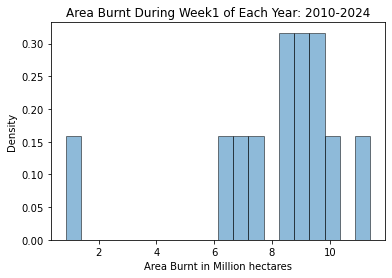

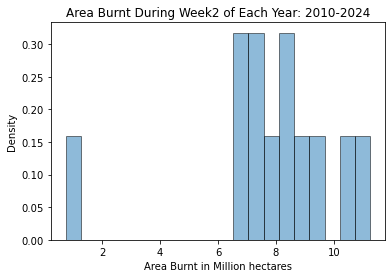

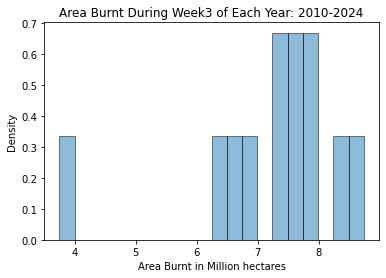

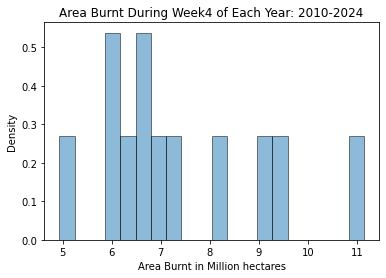

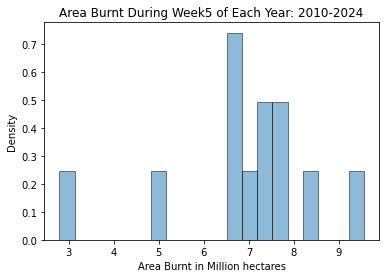

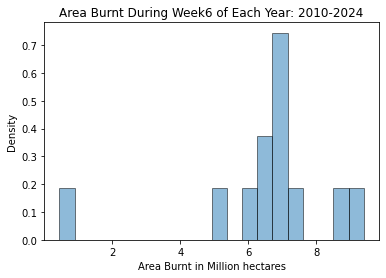

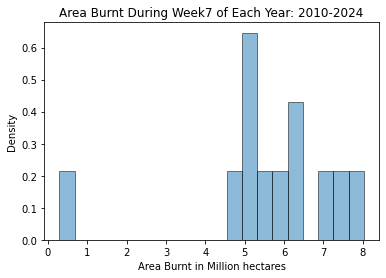

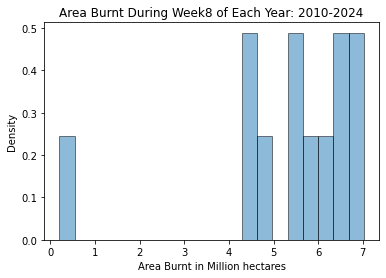

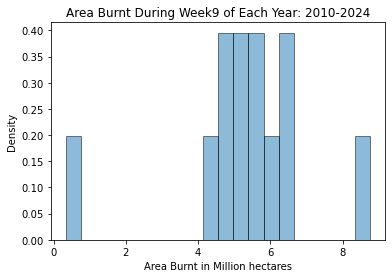

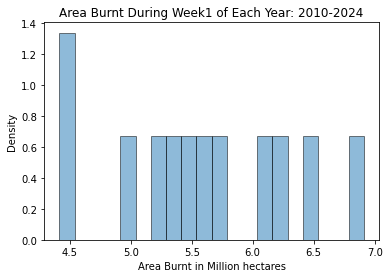

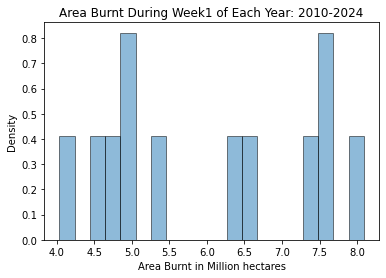

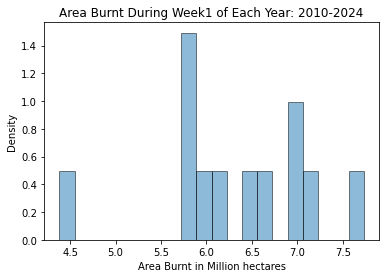

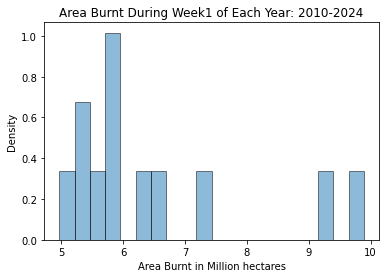

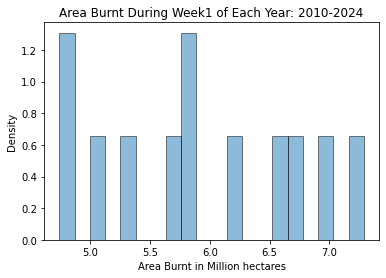

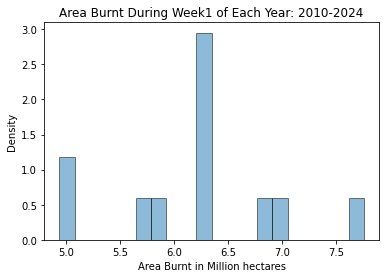

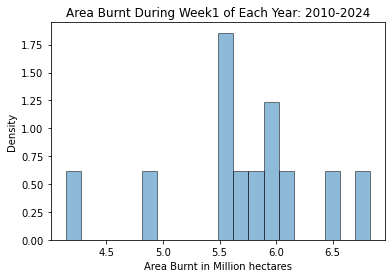

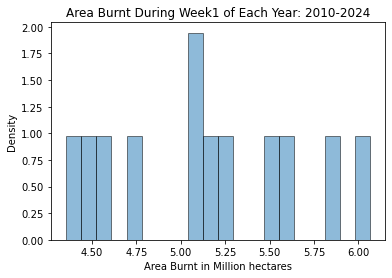

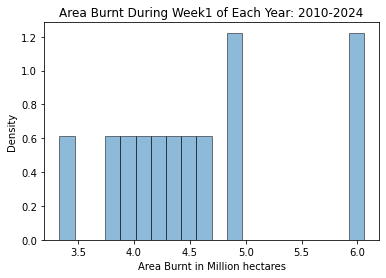

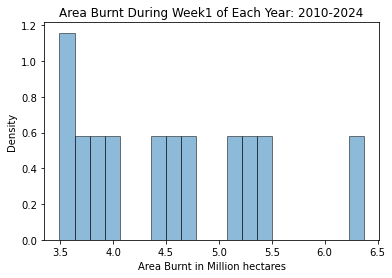

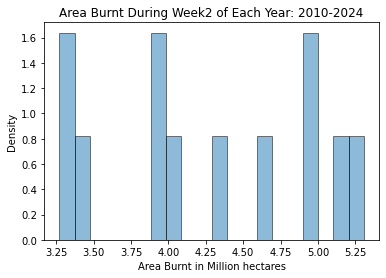

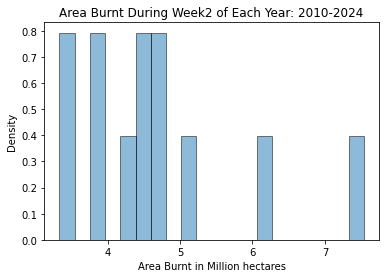

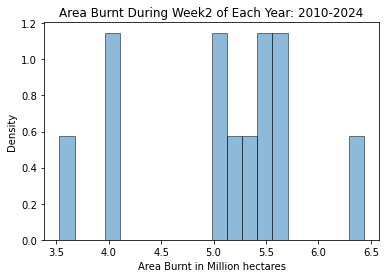

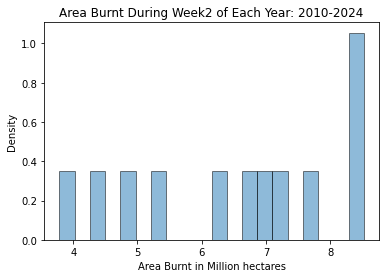

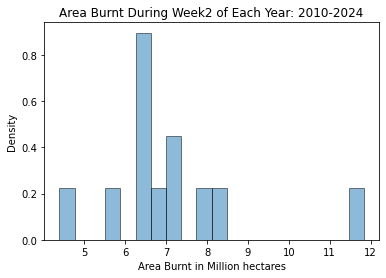

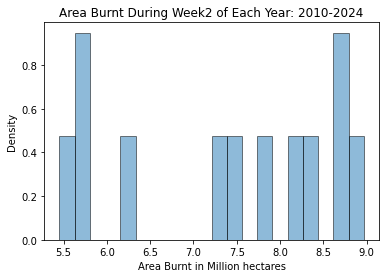

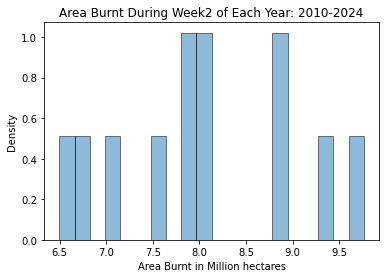

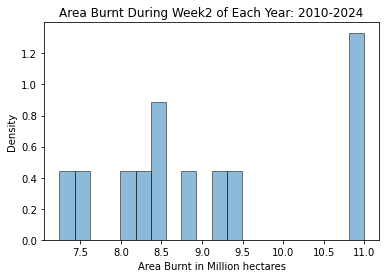

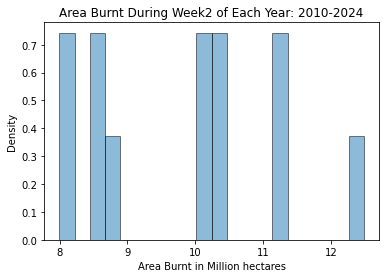

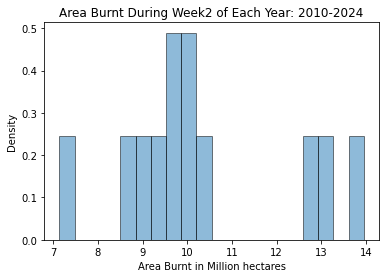

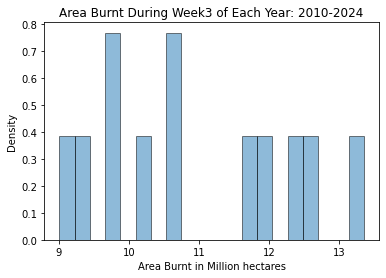

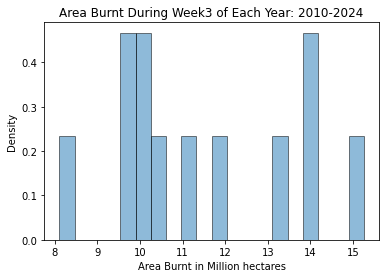

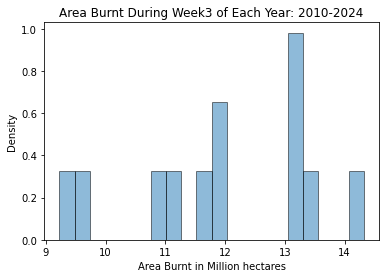

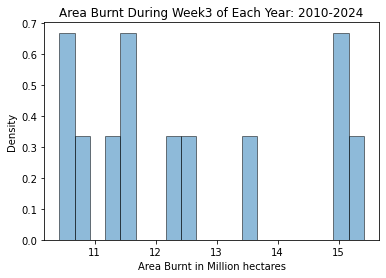

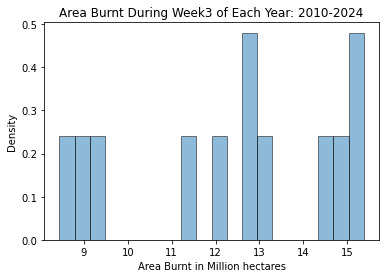

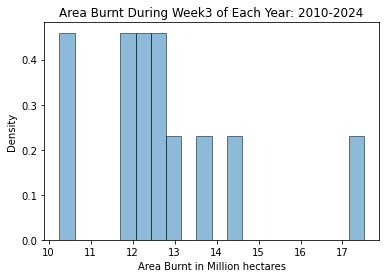

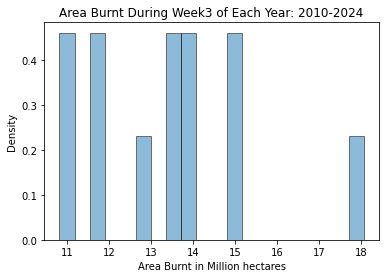

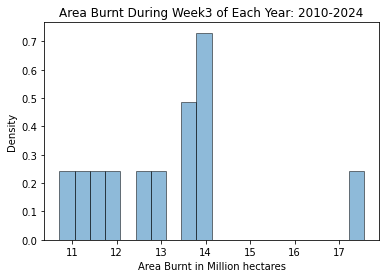

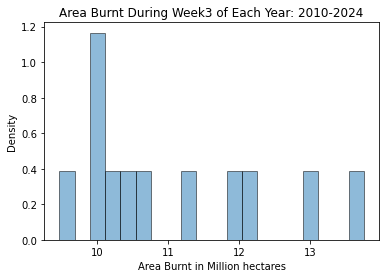

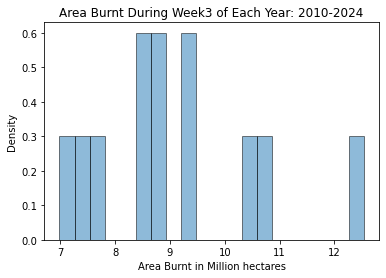

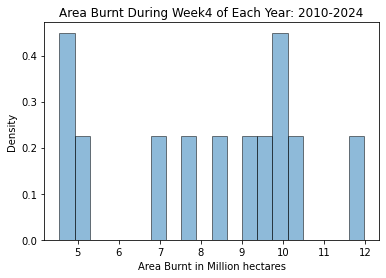

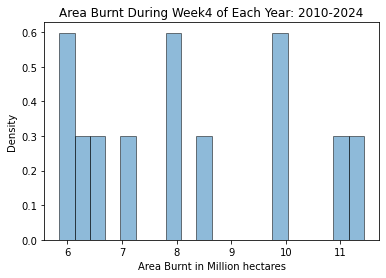

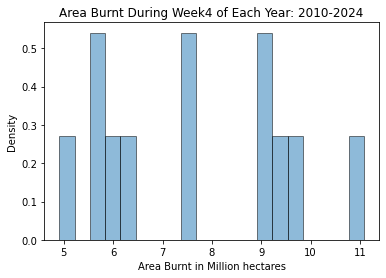

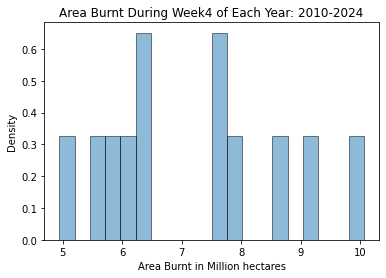

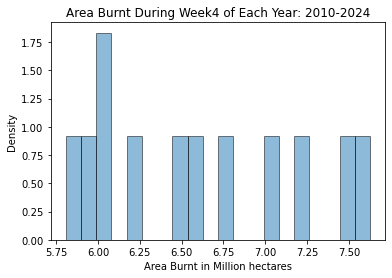

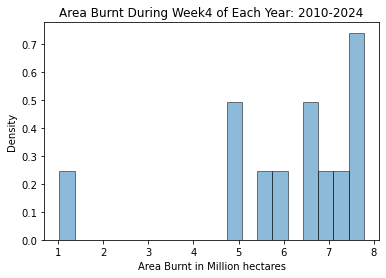

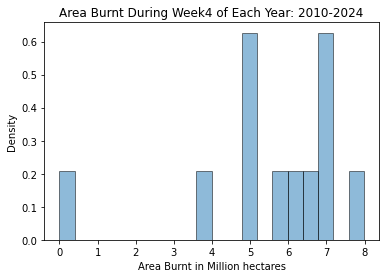

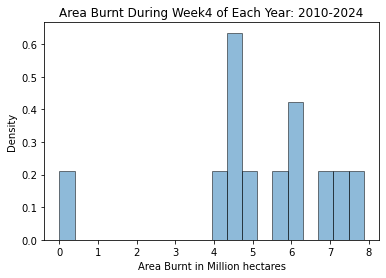

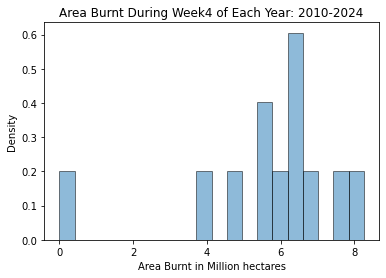

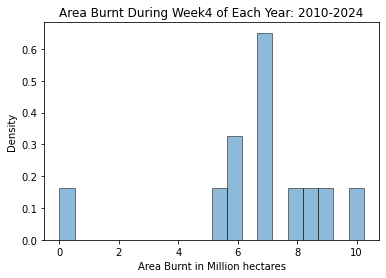

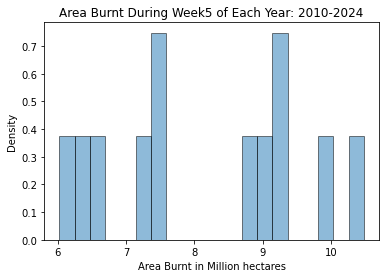

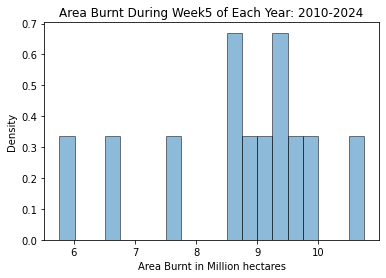

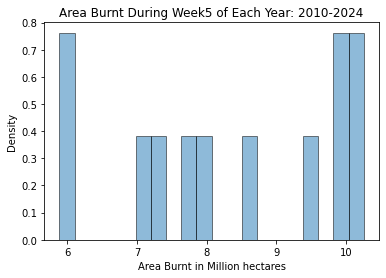

<Figure size 432x288 with 0 Axes>

In [267]:
for key, values in Wildfire_Area_Burnt_Per_Week_Dict.items():
    plt.hist(values, bins=20,edgecolor='black', density=True, alpha=0.5, label='Histogram')
    plt.title('Area Burnt During ' +key[0:5]+' of Each Year: 2010-2024')
    plt.xlabel('Area Burnt in Million hectares')
    plt.ylabel('Density')
    plt.grid(False)
    plt.show()

plt.tight_layout()

In [268]:
# The graph indicates that the probability of the area burned being between 0.9 and 1.2 in the 22nd week is 0.25
# week 1 lo 0.6 hecre land burn aye prob 0.75



In [269]:
Avg_Wildfire_Area_Burnt_Per_Year_Values=[]
for i in range(1,13):
    Avg_Wildfire_Area_Burnt_Per_Year_Values.append(filtered_df['Y'+str(2024-i)+var_value].sum()/12)

In [270]:
Avg_Wildfire_Area_Burnt_Per_Year_Values

[33.326933333333336,
 30.337618333333335,
 32.018861666666666,
 34.062261500000005,
 33.956671666666665,
 27.47459291666667,
 34.31470833333333,
 34.678599999999996,
 36.95930416666666,
 33.85835,
 32.3302025,
 36.4725625]

In [271]:
params = stats.norm.fit(Avg_Wildfire_Area_Burnt_Per_Year_Values)
norm_dist_fitted = stats.norm(*params)
D, p = stats.kstest(Avg_Wildfire_Area_Burnt_Per_Year_Values, norm_dist_fitted.cdf)

print(f"KS Statistic: {D}, p-value: {p}")
# Gamma: KS Statistic: 0.1833664203656616, p-value: 0.7506925545346744
# norm: KS Statistic: 0.1703728661068546, p-value: 0.8212588025721372


KS Statistic: 0.1703728661068546, p-value: 0.8212588025721372


In [272]:
Avg_Wildfire_Area_Burnt_Per_Year_Values_mean = np.mean(Avg_Wildfire_Area_Burnt_Per_Year_Values)
Avg_Wildfire_Area_Burnt_Per_Year_Values_std = np.std(Avg_Wildfire_Area_Burnt_Per_Year_Values)
Per_year_Avg_Weekly_Area_Burnt_alpha_mom = Avg_Wildfire_Area_Burnt_Per_Year_Values_mean ** 2 / Avg_Wildfire_Area_Burnt_Per_Year_Values_std
Per_year_Avg_Weekly_Area_Burnt_beta_mom = Avg_Wildfire_Area_Burnt_Per_Year_Values_std / Avg_Wildfire_Area_Burnt_Per_Year_Values_mean
Per_year_Avg_Weekly_Area_Burnt_alpha_mom, Per_year_Avg_Weekly_Area_Burnt_beta_mom

(450.0188476807782, 0.07403220794288799)

In [273]:
# data = Avg_Wildfire_Area_Burnt_Per_Year_Values

# l_mean = Avg_Wildfire_Area_Burnt_Per_Year_Values_mean
# l_std = Avg_Wildfire_Area_Burnt_Per_Year_Values_std
# print(l_mean,l_std)
# # Plotting the histogram

# x = np.linspace(min(data), max(data), 1000)

# y = norm.pdf(x, l_mean, l_std)
# y1=gamma.pdf(x, a=Per_year_Avg_Weekly_Area_Burnt_alpha_mom, scale=Per_year_Avg_Weekly_Area_Burnt_beta_mom)
# y2 = expon.pdf(x, scale=l_mean)
# y_fitted = norm_dist_fitted.cdf(x)
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Normal Distribution')
# plt.plot(x, y1, label='Gamma of area burnt per year Distribution')
# # plt.plot(x, y_fitted, label='Student T Distribution')
# # plt.plot(x, student_t_pdf, label='Student T Distribution')
# plt.hist(data, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
# plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024)')
# plt.xlabel('Average Area Burnt (in Million hectares) per year')
# plt.ylabel('Density')
# plt.grid(True)
# plt.legend(loc='upper right')
# plt.show()


In [274]:
with pm.Model() as wildfire_avg_area_burnt_per_year_norm_model:
    # Prior distributions for the parameters of the normal distribution
#     mu = pm.Exponential('mu', 1/12.)  # expected_mu is your guess/estimate for the mean
#     sigma = pm.Exponential('sigma', 1/12.)  # expected_sigma is your estimate for sigma
    mu = pm.Uniform('mu', lower=25, upper=40)
    sigma = pm.Uniform('sigma', lower=1, upper=10)

    # The likelihood of the observed data
    wildfire_avg_area_burnt_per_year_like = pm.Normal('wildfire_avg_area_burnt_per_year_like', mu=mu, sigma=sigma, observed=data)

    # Posterior distribution
    wildfire_avg_area_burnt_per_year_trace_norm = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 32.096


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Anurag\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


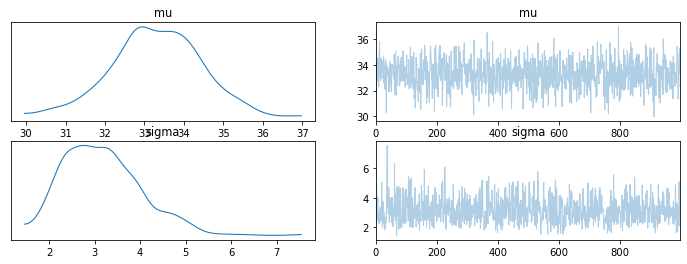

In [275]:

az.plot_trace(wildfire_avg_area_burnt_per_year_trace_norm)
plt.show()    

Mean from data: 33.31588890972221
Standard deviation from data: 2.466448815566711
Mean from PyMC3: 33.29328015797449
Sigma from PyMC3: 3.168002042500182
33.31588890972221 2.466448815566711


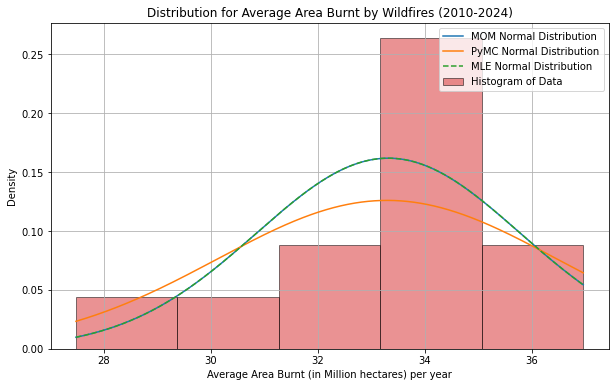

In [276]:

data = Avg_Wildfire_Area_Burnt_Per_Year_Values

# Calculate mean and standard deviation
l_mean = np.mean(data)
l_std = np.std(data)

wildfire_avg_area_burnt_per_year_trace_norm_mu = wildfire_avg_area_burnt_per_year_trace_norm['mu'].mean()
wildfire_avg_area_burnt_per_year_trace_norm_sigma = wildfire_avg_area_burnt_per_year_trace_norm['sigma'].mean()

print("Mean from data:", l_mean)
print("Standard deviation from data:", l_std)
print("Mean from PyMC3:", wildfire_avg_area_burnt_per_year_trace_norm_mu)
print("Sigma from PyMC3:", wildfire_avg_area_burnt_per_year_trace_norm_sigma)

# Set up a range of x values for the PDF plots
x = np.linspace(min(data), max(data), 1000)

# Normal Distribution using mean and std from data
y = norm.pdf(x, l_mean, l_std)

# Normal Distribution from PyMC3 results
pymc_norm_y = norm.pdf(x, wildfire_avg_area_burnt_per_year_trace_norm_mu, wildfire_avg_area_burnt_per_year_trace_norm_sigma)

# Fit a normal distribution using MLE
(mle_mu, mle_sigma) = norm.fit(data)
print(mle_mu, mle_sigma)
mle_norm_y = norm.pdf(x, mle_mu, mle_sigma)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='MOM Normal Distribution')
plt.plot(x, pymc_norm_y, label='PyMC Normal Distribution')
plt.plot(x, mle_norm_y, label='MLE Normal Distribution', linestyle='--')

# Plotting the histogram of the data
plt.hist(data, bins=5, edgecolor='black', density=True, alpha=0.5, label='Histogram of Data')

# Add titles and labels
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024)')
plt.xlabel('Average Area Burnt (in Million hectares) per year')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


In [277]:
# KS test for MOM
D_mom, p_mom = stats.kstest(data, 'norm', args=(l_mean, l_std))
print(f"MOM KS Statistic: {D_mom}, p-value: {p_mom}")

# KS test for MLE
D_mle, p_mle = stats.kstest(data, 'norm', args=(mle_mu, mle_sigma))
print(f"MLE KS Statistic: {D_mle}, p-value: {p_mle}")

# KS test for PyMC3
# Since PyMC3 parameters do not directly translate into scipy's CDF function, we need to manually apply the CDF
norm_dist_pymc = stats.norm(wildfire_avg_area_burnt_per_year_trace_norm_mu, wildfire_avg_area_burnt_per_year_trace_norm_sigma)
D_pymc, p_pymc = stats.kstest(data, lambda x: norm_dist_pymc.cdf(x))
print(f"PyMC3 KS Statistic: {D_pymc}, p-value: {p_pymc}")


MOM KS Statistic: 0.1703728661068546, p-value: 0.8212588025721372
MLE KS Statistic: 0.1703728661068546, p-value: 0.8212588025721372
PyMC3 KS Statistic: 0.177072943012301, p-value: 0.7857795440552179


# MOM/MLE Suits better for modelling Average Area Burnt (in Million hectares) per year